# Import Libraries


In [1]:
# !pip3 install opencv-python

In [1]:
import zipfile  # Library for working with ZIP archives, allowing you to compress, decompress, and manipulate ZIP files.
import requests  # Library for making HTTP requests, commonly used for fetching data from web servers.
import cv2  # OpenCV library for computer vision tasks, including image and video processing.
import matplotlib.pyplot as plt  # Library for creating visualizations like plots, charts, and graphs.
import glob  # Library for searching directories using wildcard patterns and retrieving file paths.
import random  # Library for generating random numbers and performing random operations.
import os  # Library for interacting with the operating system, providing functions for file and directory operations.


# Install the Ultralytics Package

In [3]:
# !pip install ultralytics


# Download the Dataset

In [6]:
def download_file(url, save_name):
    # Function to download a file from a given URL and save it with a specified name

    url = url  # URL of the file to be downloaded

    # Check if the file already exists in the specified path
    if not os.path.exists(save_name):
        # If the file does not exist, download it
        file = requests.get(url)  # Send a GET request to the URL
        # Write the content of the response to a file with the given name in binary mode
        open(save_name, 'wb').write(file.content)

# Call the function to download the file from the given URL and save it as 'pothole_dataset_v8.zip'
download_file(
    'https://www.dropbox.com/s/qvglw8pqo16769f/pothole_dataset_v8.zip?dl=1',
    'pothole_dataset_v8.zip'
)


In [7]:
# Function to unzip a ZIP file
def unzip(zip_file=None):
    try:
        # Attempt to open the specified ZIP file
        with zipfile.ZipFile(zip_file) as z:
            # Extract all contents of the ZIP file to the current directory
            z.extractall("./")
            print("Extracted all")
    except:
        # If there is an error (e.g., the file is not a valid ZIP file), print an error message
        print("Invalid file")

# Call the function to unzip the file 'pothole_dataset_v8.zip'
unzip('pothole_dataset_v8.zip')


Extracted all


# Visualize Images from the Dataset

In [9]:
# Function to convert bounding boxes from YOLO format to (xmin, ymin, xmax, ymax) format
def yolo2bbox(bboxes):
    # YOLO format: (x_center, y_center, width, height)
    # Convert YOLO bounding box format to (xmin, ymin, xmax, ymax)
    xmin, ymin = bboxes[0] - bboxes[2] / 2, bboxes[1] - bboxes[3] / 2
    xmax, ymax = bboxes[0] + bboxes[2] / 2, bboxes[1] + bboxes[3] / 2

    # Return the bounding box coordinates in the new format
    return xmin, ymin, xmax, ymax


In [10]:
# Function to draw bounding boxes on an image
def plot_box(image, bboxes, labels):
    # Get the height and width of the image to denormalize the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        # Convert YOLO bounding box format to (xmin, ymin, xmax, ymax)
        x1, y1, x2, y2 = yolo2bbox(box)

        # Denormalize the coordinates
        xmin = int(x1 * w)
        ymin = int(y1 * h)
        xmax = int(x2 * w)
        ymax = int(y2 * h)

        # Set the thickness of the rectangle to be drawn
        thickness = max(2, int(w / 275))

        # Draw the rectangle on the image
        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),  # Red color in BGR format
            thickness=thickness
        )
    return image

# Function to plot images with bounding boxes
def plot(image_paths, label_paths, num_samples):
    all_images = []
    # Add all .jpg and .JPG images from the given directory to the list
    all_images.extend(glob.glob(image_paths + '/*.jpg'))
    all_images.extend(glob.glob(image_paths + '/*.JPG'))

    # Sort the list of images
    all_images.sort()

    num_images = len(all_images)

    # Set up the plot
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        # Select a random image
        j = random.randint(0, num_images - 1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])

        # Read the image
        image = cv2.imread(all_images[j])

        # Open the corresponding label file
        with open(os.path.join(label_paths, image_name + '.txt'), 'r') as f:
            bboxes = []
            labels = []
            # Read all lines in the label file
            label_lines = f.readlines()
            for label_line in label_lines:
                # Parse the label and bounding box coordinates from each line
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                # Append the bounding box coordinates and label to the respective lists
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)

        # Draw the bounding boxes on the image
        result_image = plot_box(image, bboxes, labels)

        # Plot the image with bounding boxes
        plt.subplot(2, 2, i + 1)
        plt.imshow(result_image[:, :, ::-1])  # Convert BGR to RGB for plotting
        plt.axis('off')  # Hide the axis

    # Adjust layout for the plot
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()


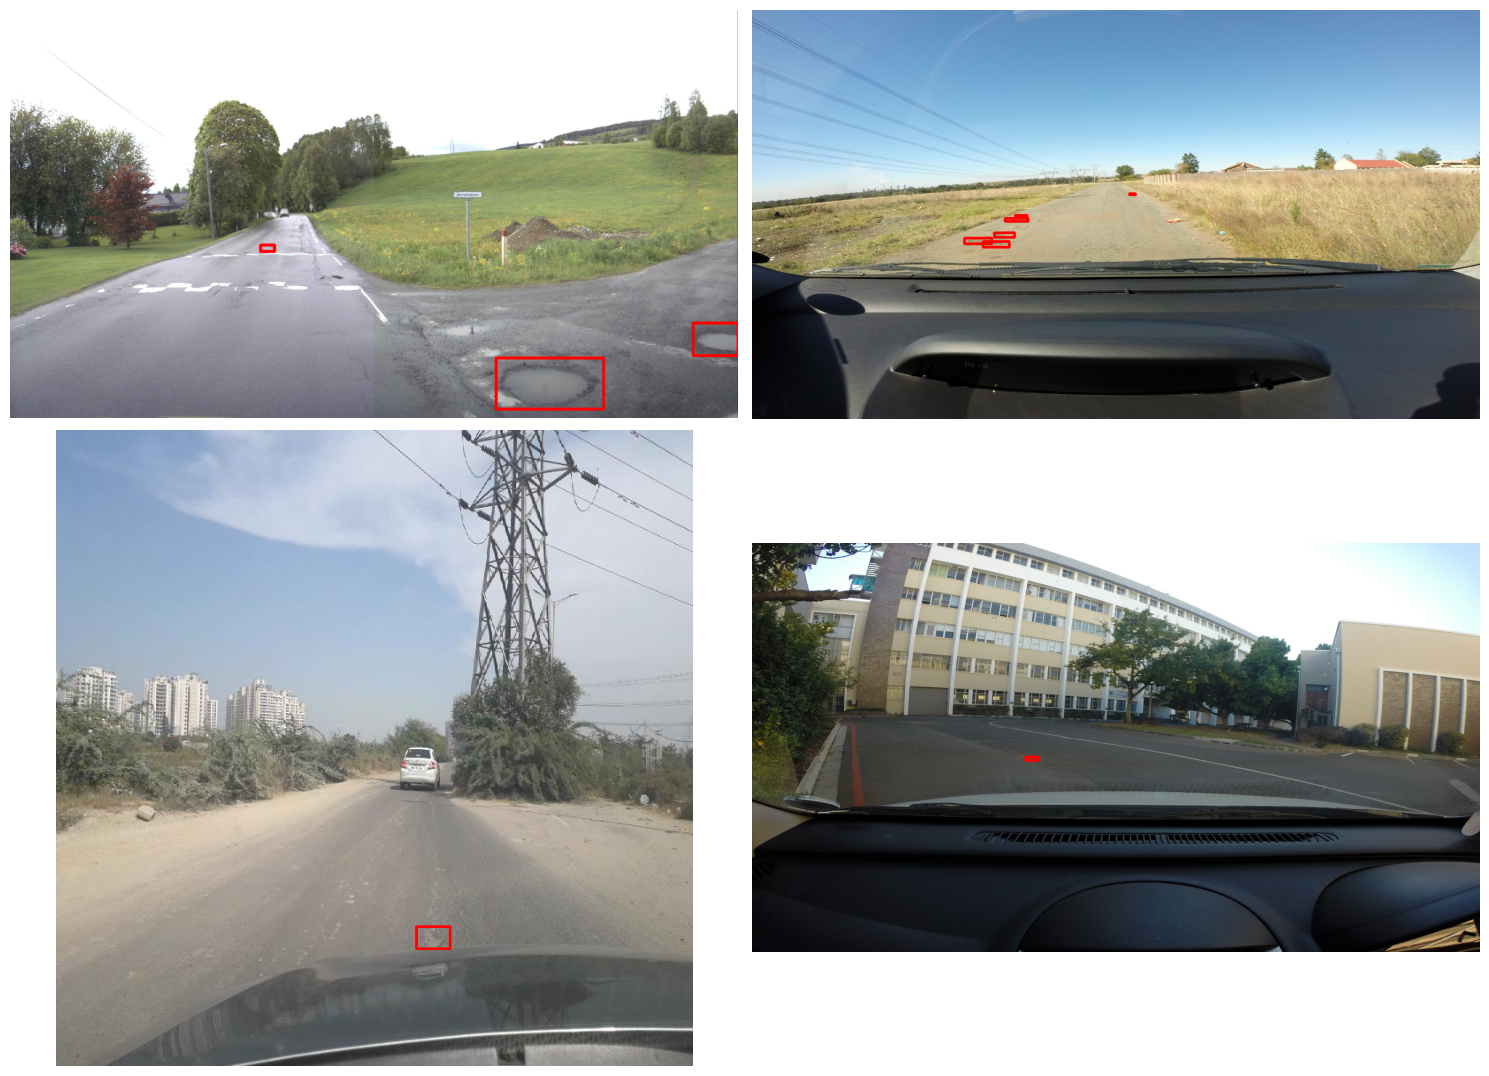

In [11]:
# Visualize a few training images.
plot(
    image_paths='datasets/pothole_dataset_v8/train/images/',
    label_paths='datasets/pothole_dataset_v8/train/labels/',
    num_samples=4,
)

# Dataset YAML File
 Create a dataset yaml file for the Ultralytics Yolo training

In [12]:
%%writefile pothole_v8.yaml
path: 'pothole_dataset_v8/'
train: 'train/images'
val: 'valid/images'

# class names
names:
  0: 'pothole'

Overwriting pothole_v8.yaml


In [ ]:
% load_ext tensorboard./runs  # replace with 'runs' directory

In [14]:
# Sample training for 5 epoch.
EPOCHS = 5
!yolo task=detect \
    mode=train \
    model=yolov8x.pt \
    imgsz=1280 \
    data=pothole_v8.yaml \
    epochs={EPOCHS} \ 
    batch=8 \
    name=yolov8x_v8_pot

Ultralytics YOLOv8.2.31 🚀 Python-3.11.9 torch-2.2.1+cu121 CUDA:0 (NVIDIA RTX A6000, 48676MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=pothole_v8.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8x_v8_pot2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

# Evaluation on Validation Images


In [15]:
!yolo task=detect \
    mode=val \
    model=./runs/detect/yolov8x_v8_pot/weights/best.pt \
    name=yolov8n_eval \
    data=pothole_v8.yaml


Ultralytics YOLOv8.2.31 🚀 Python-3.11.9 torch-2.2.1+cu121 CUDA:0 (NVIDIA RTX A6000, 48676MiB)
Model summary (fused): 268 layers, 68124531 parameters, 0 gradients, 257.4 GFLOPs
val: Scanning /home/jivitesh/Segmentation-Workshop/datasets/pothole_dataset_v8/v
val: WARNING ⚠️ /home/jivitesh/Segmentation-Workshop/datasets/pothole_dataset_v8/valid/images/G0011603.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /home/jivitesh/Segmentation-Workshop/datasets/pothole_dataset_v8/valid/images/G0011614.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /home/jivitesh/Segmentation-Workshop/datasets/pothole_dataset_v8/valid/images/G0011616.jpg: 2 duplicate labels removed
val: WARNING ⚠️ /home/jivitesh/Segmentation-Workshop/datasets/pothole_dataset_v8/valid/images/G0011661.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /home/jivitesh/Segmentation-Workshop/datasets/pothole_dataset_v8/valid/images/G0011662.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /home/jivitesh/Segmentation-Workshop/datasets/pothol

# Inference on Validation Images


In [16]:
!yolo task=detect \
mode=predict \
model=./runs/detect/yolov8x_v8_pot/weights/best.pt \
source=datasets/pothole_dataset_v8/valid/images \
imgsz=1280 \
name=yolov8x_v8_pot_infer1280 \
hide_labels=True

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.399999999999999' in the future. Please use 'show_labels' instead.
Ultralytics YOLOv8.2.31 🚀 Python-3.11.9 torch-2.2.1+cu121 CUDA:0 (NVIDIA RTX A6000, 48676MiB)
Model summary (fused): 268 layers, 68124531 parameters, 0 gradients, 257.4 GFLOPs

image 1/271 /home/jivitesh/Segmentation-Workshop/datasets/pothole_dataset_v8/valid/images/G0011195.jpg: 736x1280 2 potholes, 141.4ms
image 2/271 /home/jivitesh/Segmentation-Workshop/datasets/pothole_dataset_v8/valid/images/G0011196.jpg: 736x1280 2 potholes, 32.8ms
image 3/271 /home/jivitesh/Segmentation-Workshop/datasets/pothole_dataset_v8/valid/images/G0011242.jpg: 736x1280 (no detections), 43.8ms
image 4/271 /home/jivitesh/Segmentation-Workshop/datasets/pothole_dataset_v8/valid/images/G0011243.jpg: 736x1280 2 potholes, 37.2ms
image 5/271 /home/jivitesh/Segmentation-Workshop/datasets/pothole_dataset_v8/valid/images/G0011244.jpg: 736x1280 1 pothole, 37.8ms
image 6/271 /ho

#  Inference on Validation Images


In [17]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

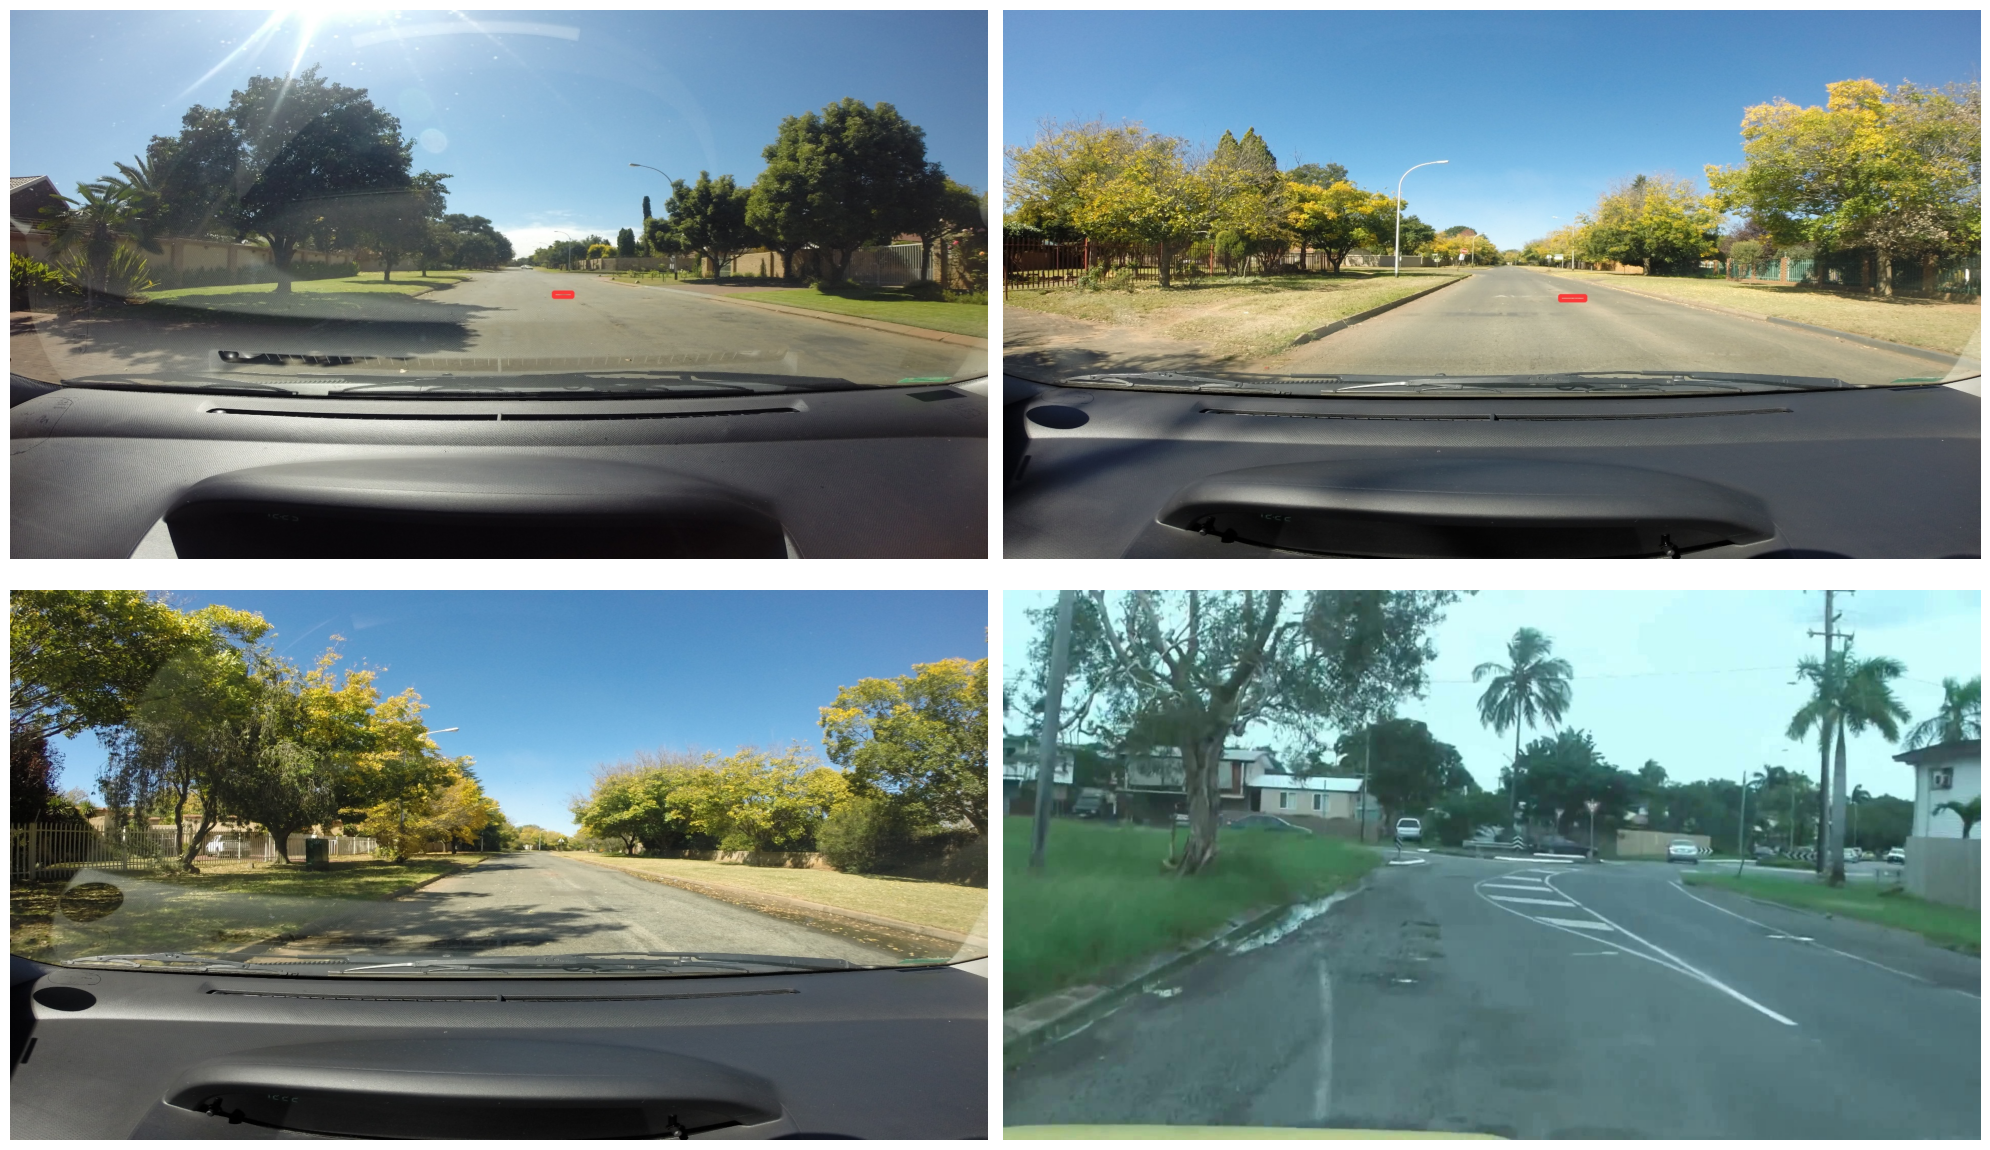

In [24]:
visualize('runs/detect/yolov8x_v8_pot_infer1280')